In [35]:
import pandas as pd


df = pd.read_csv('../scrapers/data/requirements_txt.psv', sep='|',
                names=['repo', 'date', 'requirements'])
df = df.dropna() # I need to clean this data better. 

latest_data = df.groupby('repo').max()
baskets = latest_data['requirements'].map(lambda s: s.split(',')).values

from apriori import apriori
sorter = lambda r: r.bayesian_confidence/r.confidence*r.lift
filterer = lambda r: r['bayesian_confidence'] > 0.5
rules = apriori(baskets, 60, max_k=2, filter_rule=filterer, sort_key=sorter)

In [36]:
len(rules)

682

In [26]:
%pylab inline
figsize(21,21)

Populating the interactive namespace from numpy and matplotlib


In [37]:
import networkx as nx
G = nx.Graph()

In [38]:
G.add_weighted_edges_from((r['start_items'][0], r['other_items'][0], r['confidence']) for r in rules)

In [44]:
### build size map
_counts = {}
for r in rules:
    start_item = r['start_items'][0]
    end_item = r['other_items'][0]
    if start_item not in _counts:
        _counts[start_item] = r['antecedent_occurrences']
    if end_item not in _counts:
        _counts[end_item] = r['subsequent_occurrences']

node_sizes = [] 
for node in G.nodes():
    node_sizes.append(_counts.get(node, 1))


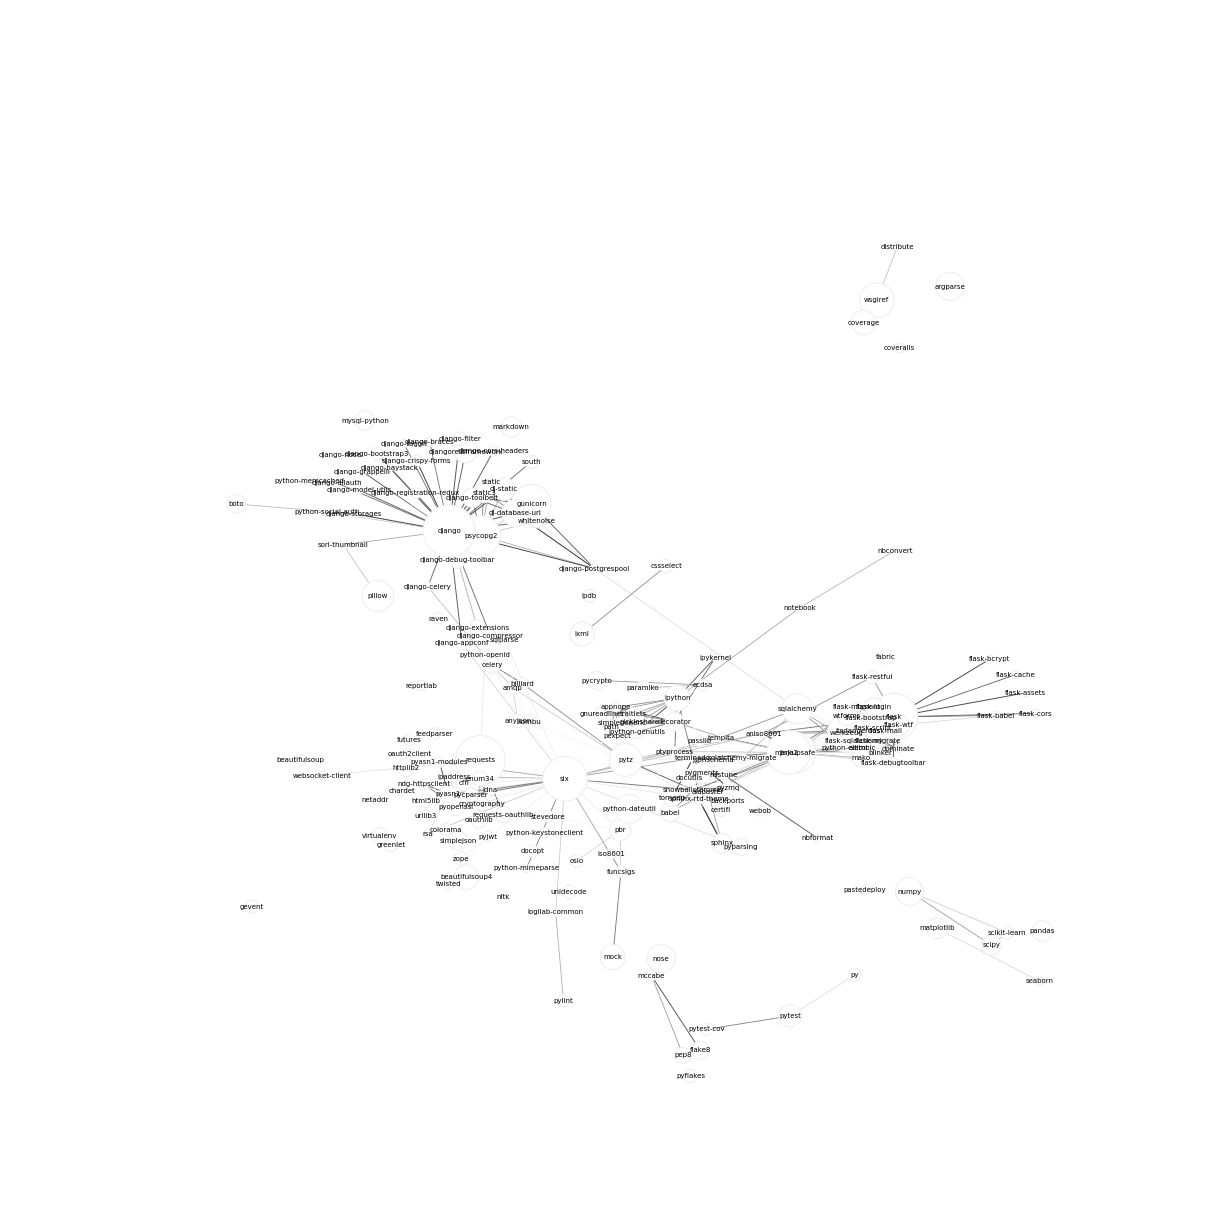

In [45]:
pos = nx.spring_layout(G, iterations=35, k=0.1)
ax = plt.subplot(111)
cmap = plt.get_cmap("Greys")

weights = [G[x][y]['weight'] for x,y in G.edges()]
weight = lambda x: abs(x)**(2)
width = [weight(w) for w in weights]

nx.draw_networkx_edges(G, pos, ax=ax, edge_vmin=0.55, edge_vmax=1.1, edge_cmap=cmap, edge_color = width, width=width)
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, linewidths=1, node_color="white")
nx.draw_networkx_labels(G, pos,font_size=7, ax=ax)
plt.axis("off");
plt.savefig('weighted_network.png', bbox_inches="tight", dpi=300)